In [485]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

#membaca data file csv
data_train = pd.read_csv('DailyDelhiClimateTrain.csv')
data_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [486]:
data_train.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Text(0.5, 1.0, 'Daily Delhi Climate')

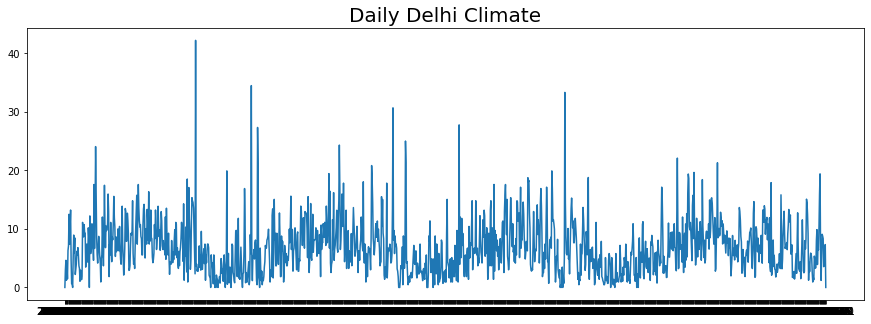

In [487]:
#membuat grafik
date = data_train['date'].values
wind_speed = data_train['wind_speed'].values
     
plt.figure(figsize=(15,5))
plt.plot(date, wind_speed)
plt.title('Daily Delhi Climate', fontsize=20)

In [488]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [489]:
from sklearn.model_selection import train_test_split

#membagi data ke training data dan validation data
wind_speed_train, wind_speed_test = train_test_split(wind_speed, test_size=0.2)

print('Jumlah Total Data Wind Speed', len(wind_speed))
print('Jumlah Data Wind Speed Latihan', len(wind_speed_train))
print('Jumlah Data Wind Speed Tes', len(wind_speed_test))

Jumlah Total Data Wind Speed 1462
Jumlah Data Wind Speed Latihan 1169
Jumlah Data Wind Speed Tes 293


In [490]:
#mengubah ke data set
wind_speed_set = windowed_dataset(wind_speed, window_size=60, batch_size=100, shuffle_buffer=1000)
wind_speed_train_set = windowed_dataset(wind_speed_train, window_size=60, batch_size=100, shuffle_buffer=1000)
wind_speed_test_set = windowed_dataset(wind_speed_test, window_size=60, batch_size=100, shuffle_buffer=1000)

In [491]:
#menghitung 10% dari skala data
maximum = max(wind_speed)
minimum = min(wind_speed)
maximum_mae = (maximum-minimum)*0.1
print(maximum_mae)

4.222


In [492]:
#membuat sistem callback
class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, maximum_mae):
       self.maximum_mae = maximum_mae


    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') < self.maximum_mae):
          print("\MAE dari model < 10% skala data.")
          self.model.stop_training = True
callbacks = myCallback(maximum_mae)

In [493]:
#membuat model sequential
model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(48, return_sequences=True),
      tf.keras.layers.LSTM(48),
      tf.keras.layers.Dense(24, activation="relu"),
      tf.keras.layers.Dense(8, activation="relu"),
      tf.keras.layers.Dense(1),
])

In [494]:
#membuat optimizers
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(wind_speed_train_set, validation_data=(wind_speed_test_set), verbose=2, epochs=200, callbacks=[callbacks])

Epoch 1/200
12/12 - 3s - loss: 6.3149 - mae: 6.8069 - val_loss: 6.7177 - val_mae: 7.2062
Epoch 2/200
12/12 - 2s - loss: 6.2998 - mae: 6.7914 - val_loss: 6.6985 - val_mae: 7.1864
Epoch 3/200
12/12 - 2s - loss: 6.2789 - mae: 6.7701 - val_loss: 6.6758 - val_mae: 7.1630
Epoch 4/200
12/12 - 2s - loss: 6.2535 - mae: 6.7440 - val_loss: 6.6454 - val_mae: 7.1316
Epoch 5/200
12/12 - 2s - loss: 6.2167 - mae: 6.7067 - val_loss: 6.6015 - val_mae: 7.0878
Epoch 6/200
12/12 - 2s - loss: 6.1692 - mae: 6.6594 - val_loss: 6.5525 - val_mae: 7.0392
Epoch 7/200
12/12 - 2s - loss: 6.1191 - mae: 6.6094 - val_loss: 6.5028 - val_mae: 6.9896
Epoch 8/200
12/12 - 2s - loss: 6.0693 - mae: 6.5595 - val_loss: 6.4549 - val_mae: 6.9416
Epoch 9/200
12/12 - 2s - loss: 6.0244 - mae: 6.5144 - val_loss: 6.4179 - val_mae: 6.9046
Epoch 10/200
12/12 - 2s - loss: 5.9926 - mae: 6.4824 - val_loss: 6.3917 - val_mae: 6.8782
Epoch 11/200
12/12 - 2s - loss: 5.9671 - mae: 6.4566 - val_loss: 6.3670 - val_mae: 6.8532
Epoch 12/200
12/12 

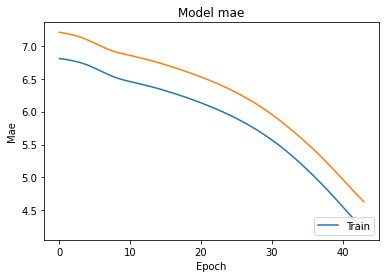

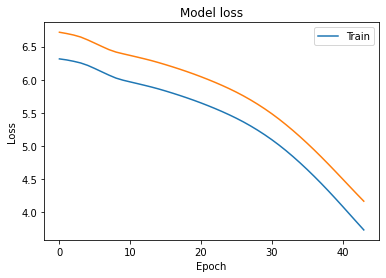

In [497]:
# visualisasi hasil data training (Plot accuracy & loss model)

import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 

mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(mae, label='Training Mae')
plt.plot(val_mae, label='Validation Mae')
plt.title('Model mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()